In [1]:
import hylite
from hylite import io

### 1. Data types

Hyperspectral data can take many forms. *hylite* uses polymorphic data structures to make analyses as generic and as smooth as possible, such that most analyses conducted on e.g. image data can also be executed on e.g. hypercloud data.

Generally speaking, hyperspectral data comes in two forms: (1) spectral lists (e.g. spectral libraries, hyperclouds), or (2) spectral data cubes (e.g., hyperspectral images). *hylite* thus implements a generic `HyData` class that implements basic functions that are independent of spectral dimension, which is then extended in child classes to add specific functionality for different hyperspectral data types. These are:

* HyImage - for hyperspectral image cubes.
* HyCloud - for hypercloud data (spectra associated with spatially located points).
* HyLibrary - for spectral library data.

**Exercise:** Explore the documentation for the different data objects using the `?` operator

In [14]:
from hylite import HyData, HyImage, HyCloud, HyLibrary, HyHeader

In [19]:
HyLibrary?

### 2. Metadata and header files

In keeping with the standard ENVI file format, metadata associated with hyperspectral datasets (e.g. band widths and wavelengths, acquisition parameters, etc.) can be stored in a simple text header (.hdr) file. 

Thus, all *hylite* data objects will have a `foo.header` attributed that stores this information. This inherits from pythons inbuilt dictionary type, so specific keywords can be accessed or set using `foo.header['some_param']`.

**Exercise:** Load an image dataset and view the header metadata

In [26]:
image = io.load( 'test_data/image.hdr' )

test_data/image.hdr test_data/image.dat


In [ ]:
image.header.print()

*hylite* uses these header files to store a variety of different information, such as the camera position and orientation information needed to project images onto point clouds or render hyperclouds as 2-D images.

**Exercise:** Load a hypercloud and view the header metadata

In [28]:
cloud = io.load( 'test_data/hypercloud.ply' )

In [ ]:
cloud.header.print()

### 3. Data access

Most hyperspectral analyses require some form of custom data munging, so the raw hyperspectral data arrays are left very exposed in *hylite*. Any `HyData` instance (including e.g. `HyImage` or `HyCloud` datasets) have a `foo.data` numpy array that contains the raw spectra. 

The shape of this array will vary from 2-D (id,band) for spectral libraries and hyperclouds to 3-D (x,y,band) for image cubes.

In [43]:
print(cloud.data.shape, "= (pointID, bandID)")

(354313, 50) = (pointID, bandID)


In [44]:
print(image.data.shape, "= (x,y,bandID)")

(269, 87, 450) = (x,y,bandID)


------
**Important note:** Hyperspectral bands can be referenced based on either their index (e.g. band number 10), or by the wavelength specified in the image metadata (e.g. 1000 nm). To seamlessly distinguish these two methods, hylite treats integer values (e.g., 1, 2, 1000) as indices and floating point values (e.g. 450.0, 750.0, 1000.0) as wavelengths (in the units defined in the header file, which are normally nanometers). 

----

Wavelengths can be converted to band indices using the `get_band_index` function, which returns the closest band to the specified wavelength.

In [35]:
print("Index of 2200. nanometers in hypercloud:", cloud.get_band_index(2200.0))

Index of 2200. nanometers in hypercloud: 15


In [48]:
print("Index of 2200. nanometers in image:", image.get_band_index(2200.0))

Index of 2200. nanometers in image: 393


Similarly, band indexes can be converted to wavelengths using the get_wavelengths() function, which returns an array containing the wavelength for each band.

In [49]:
print( image.get_wavelengths()[393])

2198.1


Hyperclouds have several additional data arrays containing geometric attributes and (if defined) point colours and normal vectors. These can be accessed using:
* `foo.xyz` (point positions)
* `foo.rgb` (point colours from e.g. SfM model, if defined)
* `foo.normals` (point normals, if defined)

In [ ]:
print("Point colours:\n", cloud.rgb)

### 4. Data visualisation

Each of the hyperspectral data types has a `quick_plot` function, although these take different arguments and draw data differently depending on the type (e.g. spectral library vs images). Again, the `?` operator provides easy access to the documentation for these different plotting tools.

**Exercise:** View `quick_plot` function definition for different data types

In [37]:
cloud.quick_plot?

In [ ]:
image.quick_plot?

The global `hylite.RGB` variable contains (approximate) wavelength values for red, green and blue light, and is a convenient way to generate true-colour plots:

(680.0, 550.0, 505.0)


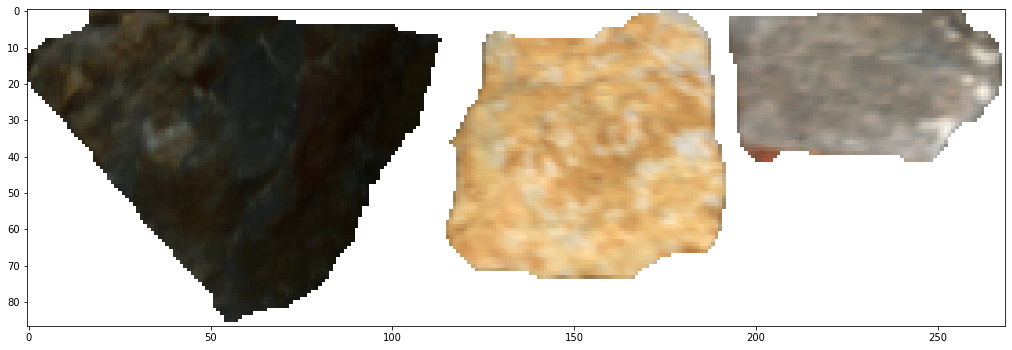

In [50]:
fig,ax = image.quick_plot(hylite.RGB)
print(hylite.RGB)
fig.show()

Unlike images, hyperclouds can have per-point colours that are independent of the hyperspectral data (e.g. based on the SfM pointcloud used to capture hypercloud geometry). These can be accessed by plotting `'rgb'`.

**Exercise**: *Experiment with 'klm' to plot normal vectors and 'xyz' to plot point positions. Also try rearranging the orders of the letters to generate different colour mappings*

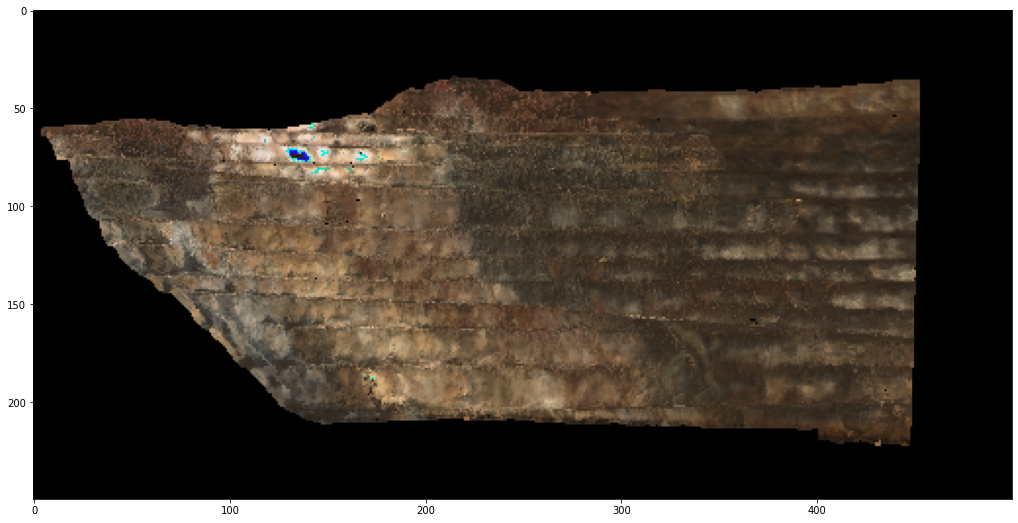

In [72]:
fig,ax = cloud.quick_plot(cloud.header.get_camera(0), 'rgb', fill_holes=True)
fig.show()

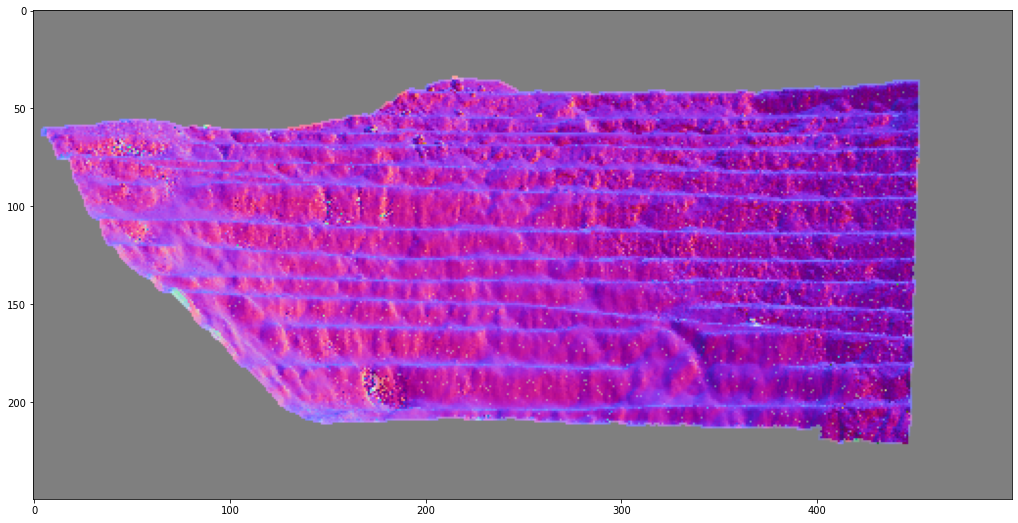

In [68]:
fig,ax = cloud.quick_plot(cloud.header.get_camera(0), 'klm', fill_holes=True)
fig.show()

Arbitrary visualisations of individual or ternary band combinations can also be easily created using *quick_plot*. Some convenient ternary combinations are included in `hylite.SWIR` and (if you have LWIR data) `hylite.LWIR`.

(2200.0, 2250.0, 2350.0)


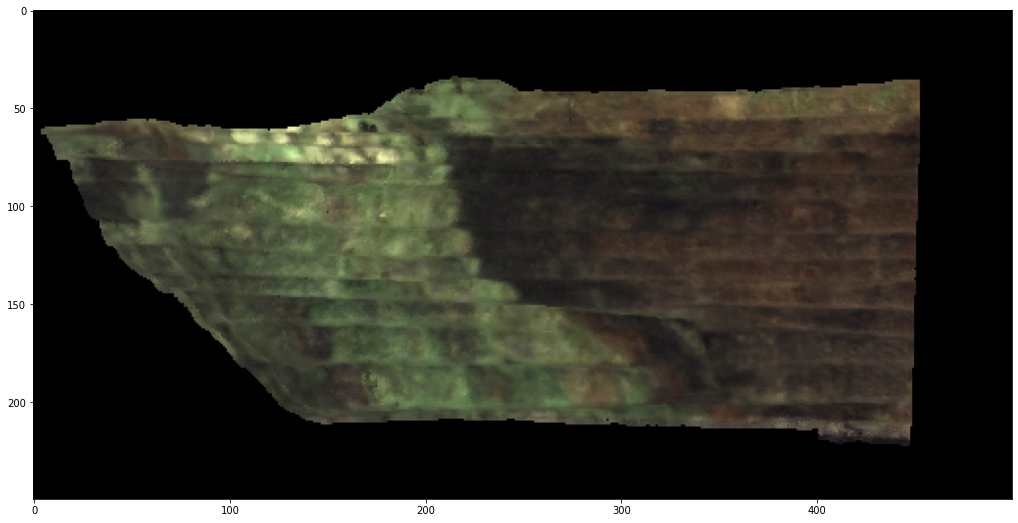

In [76]:
fig,ax = cloud.quick_plot(cloud.header.get_camera(0), hylite.SWIR, fill_holes=True)
print(hylite.SWIR)
fig.show()

(<Figure size 1296x419.152 with 1 Axes>, <AxesSubplot:>)

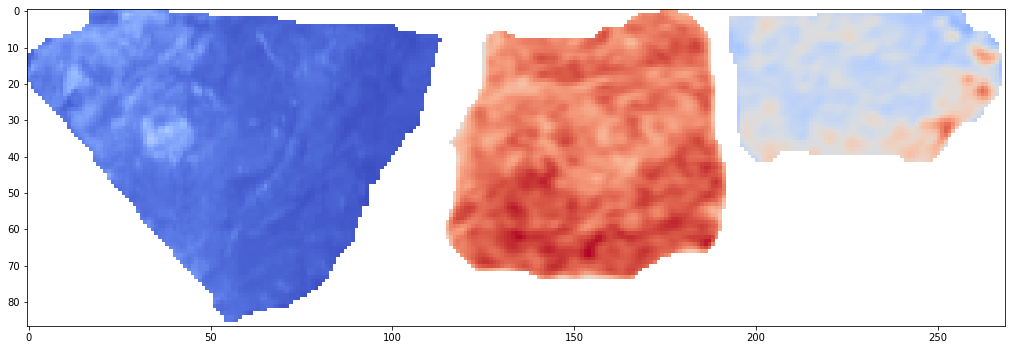

In [78]:
image.quick_plot( 1000.0, cmap='coolwarm' )

### 5. Spectral libraries and spectral caterpillars  🐛

It is often convenient to quickly summarise all of the spectra in a dataset. This can be done using the `foo.plot_spectra` function, which generates a *spectral caterpillar* defined by the median (black) and 5th, 25th, 75th and 95th percentiles of each band (grey envelopes). Specific point or pixel spectra can also be added using the `indices` argument.

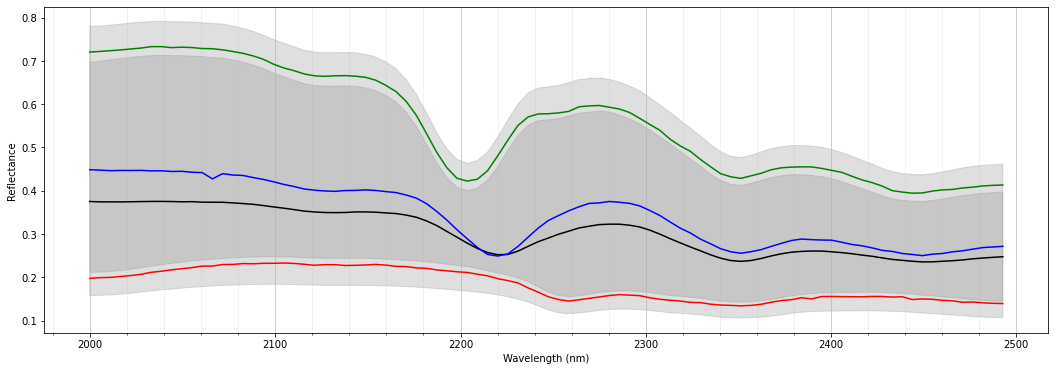

In [79]:
fig,ax = image.plot_spectra(band_range=(2000.,2500.), indices=[(50,30), (150,30), (230,30)], colours=['r','g','b'])
fig.show()

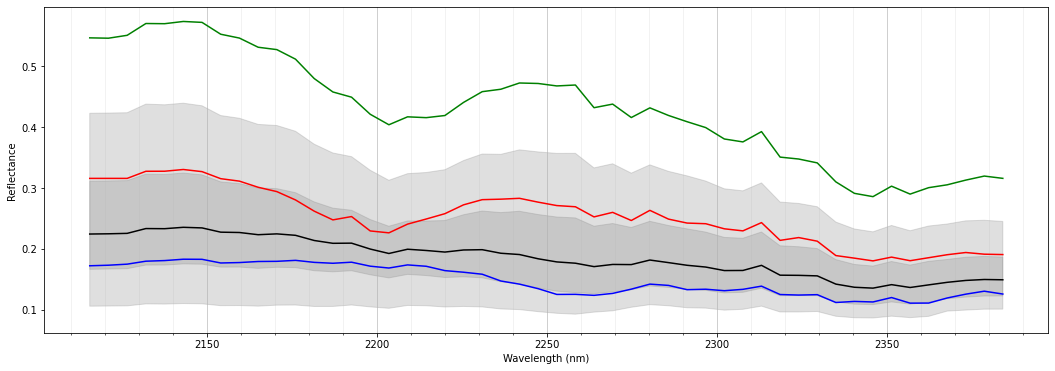

In [81]:
fig,ax = cloud.plot_spectra(indices=[108113,82475,326198], colours=['r','g','b'])
fig.show()

Spectral libraries can also be loaded and plotted for reference

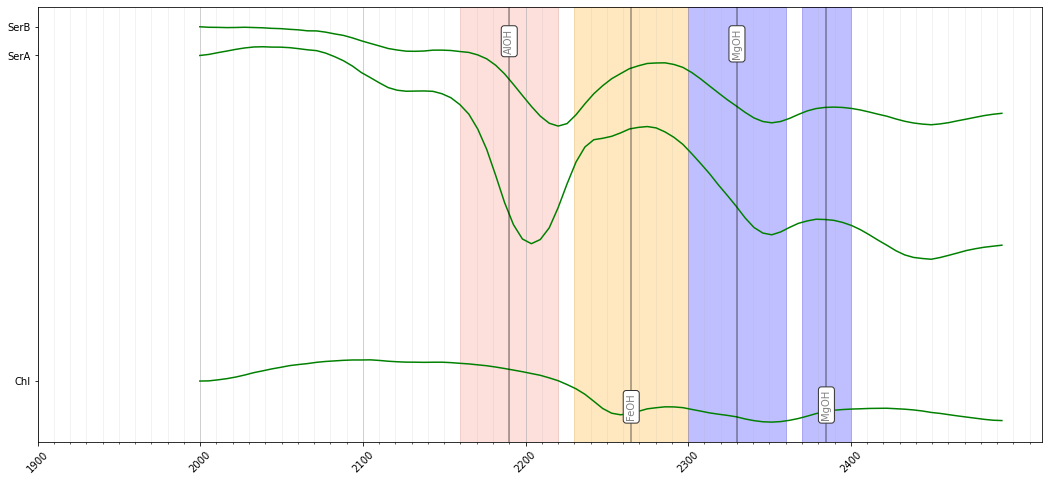

In [84]:
lib = io.load( 'test_data/library.csv' )
fig,ax = lib.quick_plot(band_range=(2000.,2500.))
fig.show()

### 6. Saving results

Finally, once some form of processing has been achieved, data can be saved using the `io.save` function. This automatically determines the data type and generates the appropriate files.

In [85]:
io.save?

/Users/thiele67/opt/anaconda3/envs/test/lib/python3.7/site-packages/spectral-0.22.2-py3.7.egg/spectral/io/envi.py:684: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  fout.write(data.tostring())


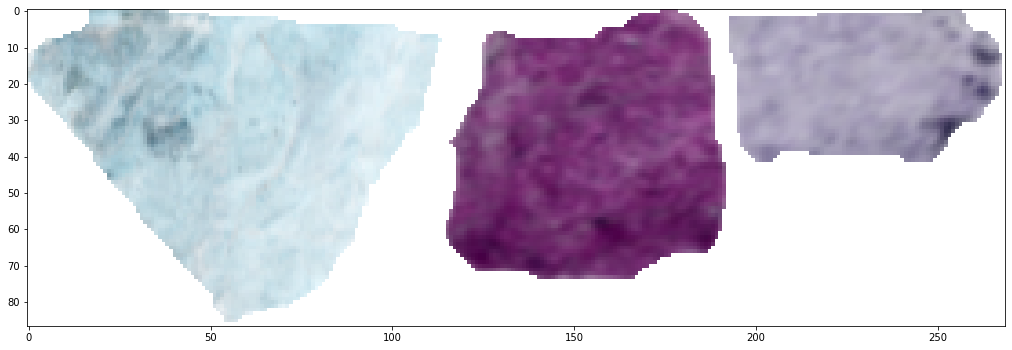

In [90]:
out = image.copy() # make a copy of the dataset as otherwise we modify it inplace
out.data = 1.0 - image.data # apply some voodoo magic
out.quick_plot( hylite.SWIR )

# save our processed dataset
io.save( './rocks.hdr', out )